In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import poligrain as plg
import xarray as xr

In [3]:
ds_gauges = xr.open_dataset("./data/openmrg_municp_gauge.nc")
ds_cmls = xr.open_dataset("./data/openmrg_cml.nc")
ds_rad = xr.open_dataset("./data/openmrg_rad.nc")
ds_gauges_smhi = xr.open_dataset("./data/openmrg_smhi_gauge.nc")

In [4]:
# ds_rad = ds_rad.isel(y=slice(None, None, -1))

# Project data

In [5]:
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

In [6]:
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, ref_str
)

ds_gauges_smhi.coords["x"], ds_gauges_smhi.coords["y"] = (
    plg.spatial.project_point_coordinates(
        ds_gauges_smhi.lon, ds_gauges_smhi.lat, ref_str
    )
)

In [7]:
# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

In [8]:
# Projected radar coords
ds_rad.coords["xs"], ds_rad.coords["ys"] = plg.spatial.project_point_coordinates(
    ds_rad.longitudes, ds_rad.latitudes, ref_str
)

In [9]:
# This is not correct, but I have to quickly create a 1D array
# for x and y with the projection that has been used above
ds_rad["x"] = ds_rad.xs.isel(y=20)
ds_rad["y"] = ds_rad.ys.isel(x=20)

## Transform CML data from `xarray.Dataset` to `pandas.DataFrame`

This is currently still needed because the old RADOLAN code use pandas for gauge and CML data

In [10]:
df_cmls = ds_cmls.to_dataframe().swaplevel()
df_cmls["station_id"] = df_cmls.index.get_level_values(1)
df_cmls.index = df_cmls.index.droplevel(1)
df_cmls["sensor_type"] = "cml_ericsson"
df_cmls["rainfall_amount"] = df_cmls.R
df_cmls.head(3)

,sublink_id,site_0_lat,site_0_lon,site_1_lat,site_1_lon,frequency,polarization,length,quantile,R,site_0_x,site_0_y,site_1_x,site_1_y,x,y,station_id,sensor_type,rainfall_amount
time,,,,,,,,,,,,,,,,,,,
2015-07-25 12:30:00,sublink_1,57.70368,11.99507,57.69785,11.9911,28206.5,v,691.44,0.8,0.081734,678461.430339,6.399665e+06,678253.619459,6.399006e+06,678357.524899,6.399335e+06,10001,cml_ericsson,0.081734
2015-07-25 12:35:00,sublink_1,57.70368,11.99507,57.69785,11.9911,28206.5,v,691.44,0.8,0.116602,678461.430339,6.399665e+06,678253.619459,6.399006e+06,678357.524899,6.399335e+06,10001,cml_ericsson,0.116602
2015-07-25 12:40:00,sublink_1,57.70368,11.99507,57.69785,11.9911,28206.5,v,691.44,0.8,0.153880,678461.430339,6.399665e+06,678253.619459,6.399006e+06,678357.524899,6.399335e+06,10001,cml_ericsson,0.153880


In [11]:
from mergeplg import radolan

In [12]:
# x_grid, y_grid = np.meshgrid(ds_rad.x.values, ds_rad.y.values)

intersection_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cmls.site_0_x.values,
    y1_line=ds_cmls.site_0_y.values,
    x2_line=ds_cmls.site_1_x.values,
    y2_line=ds_cmls.site_1_y.values,
    cml_id=ds_cmls.cml_id.values,
    x_grid=ds_rad.xs.data,
    y_grid=ds_rad.ys.data,
    grid_point_location="lower_left",
)

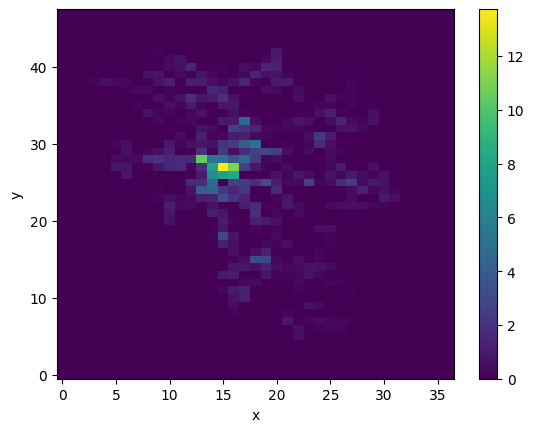

In [13]:
intersection_weights.sum(dim="cml_id").plot();

In [14]:
# need to set this variable since my old code starts with this
ds_rad["RH"] = ds_rad.rainfall_amount

In [15]:
ds_radolan_t_list = []
df_stations_t_list = []
for t in ds_rad.time.data:
    ds_radolan_t, df_stations_t = radolan.processing.rh_to_rw(
        ds_radolan_t=ds_rad.sel(time=t),
        df_stations_t=df_cmls.loc[t, :],
        allow_gauge_and_cml=True,
        intersect_weights=intersection_weights,
        max_distance=30e3,
    )
    ds_radolan_t_list.append(ds_radolan_t)
    df_stations_t_list.append(df_stations_t)

In [16]:
ds_radolan = xr.concat(ds_radolan_t_list, dim="time")
ds_radolan

<xarray.Dataset> Size: 9MB
Dimensions:                      (time: 31, y: 48, x: 37)
Coordinates:
  * time                         (time) datetime64[ns] 248B 2015-07-25T12:30:...
  * x                            (x) float64 296B 6.461e+05 ... 7.174e+05
  * y                            (y) float64 384B 6.346e+06 ... 6.439e+06
    xs                           (y, x) float64 14kB 6.457e+05 ... 7.157e+05
    ys                           (y, x) float64 14kB 6.343e+06 ... 6.441e+06
Data variables: (12/22)
    crs                          (time) int32 124B 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    latitudes                    (time, y, x) float32 220kB 57.21 ... 58.06
    longitudes                   (time, y, x) float32 220kB 11.41 ... 12.66
    rainfall_amount              (time, y, x) float64 440kB 0.01078 ... 0.05403
    RH                           (time, y, x) float64 440kB 0.01078 ... 0.05403
    RG                           (time, y, x) float64 440kB 0.01078 ... 0.05403
    ...                           ...
    mulfak_relevant              (time, y, x) float64 440kB 0.01078 ... 0.05403
    RW_not_rounded               (time, y, x) float64 440kB 0.01078 ... 0.05403
    RW                           (time, y, x) float64 440kB 0.0 0.0 ... 0.0 0.0
    RW_interim                   (time, y, x) float64 440kB 0.01078 ... 0.05403
    RR                           (time, y, x) float64 440kB nan nan ... nan nan
    RW_no_station_fill           (time, y, x) float64 440kB 0.0 0.0 ... 0.0 0.0
Attributes:
    source:       Swedish Meteorological and Hydrological Institute (SMHI), H...
    contact:      hydro.fou@smhi.se, remco.vandebeek@smhi.se
    title:        OpenMRG-Radar
    license:      https://creativecommons.org/licenses/by-sa/4.0
    version:      1.1
    doi:          https://doi.org/10.5281/zenodo.6673750
    proj_string:  +proj=stere +lat_ts=60 +ellps=bessel +lon_0=14 +lat_0=90
    comment:      Created by Remco van de Beek, Victor Näslund and Johan Thur...

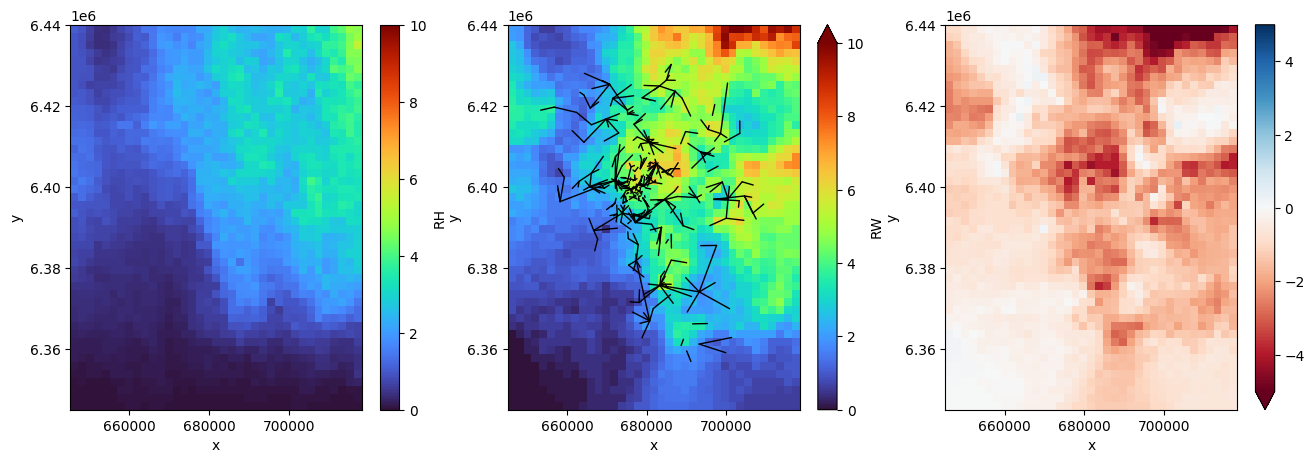

In [17]:
vmin, vmax = 0, 10
cmap = "turbo"
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
ds_radolan.sum(dim="time").RH.plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap=cmap)
ds_radolan.sum(dim="time").RW.plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap=cmap)
(ds_radolan.sum(dim="time").RH - ds_radolan.sum(dim="time").RW).plot(
    ax=axs[2],
    vmin=-5,
    vmax=5,
    cmap="RdBu",
)

plg.plot_map.scatter_lines(
    x0=ds_cmls.site_0_x,
    x1=ds_cmls.site_1_x,
    y0=ds_cmls.site_0_y,
    y1=ds_cmls.site_1_y,
    ax=axs[1],
    s=1,
    c="k",
)

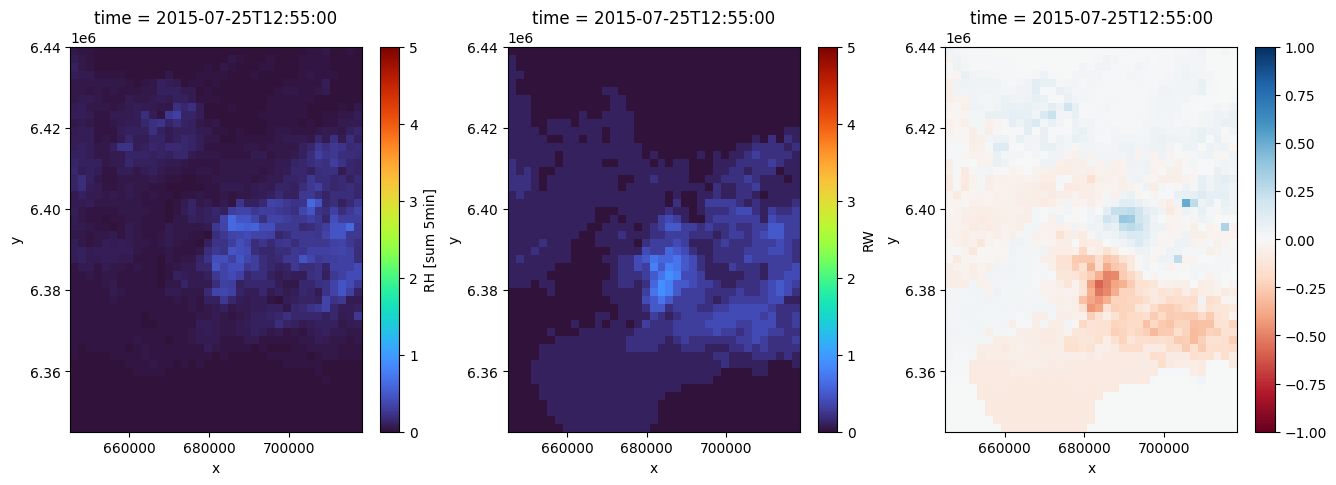

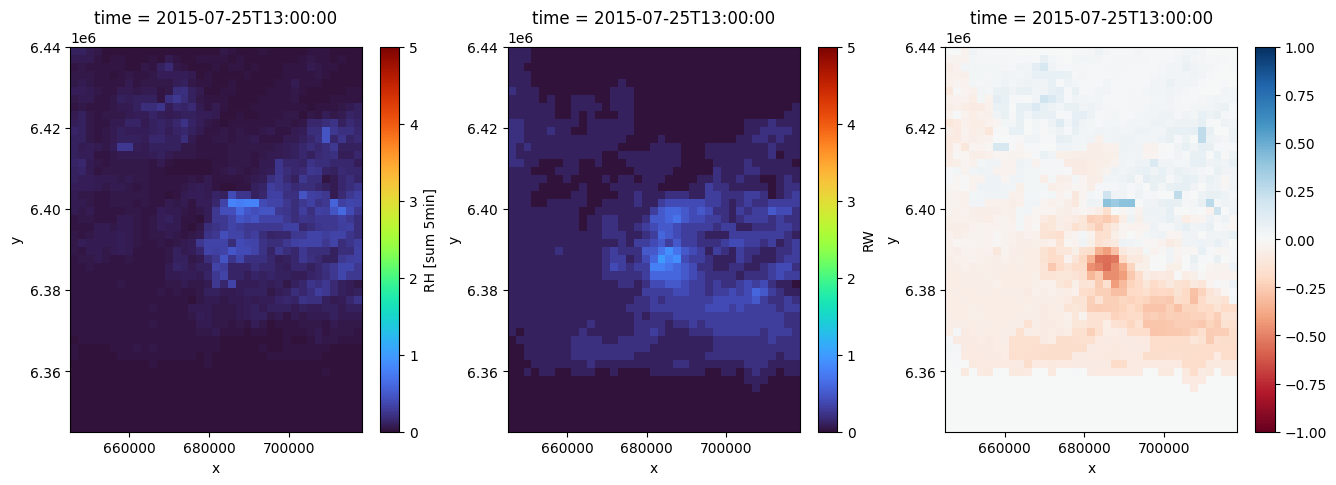

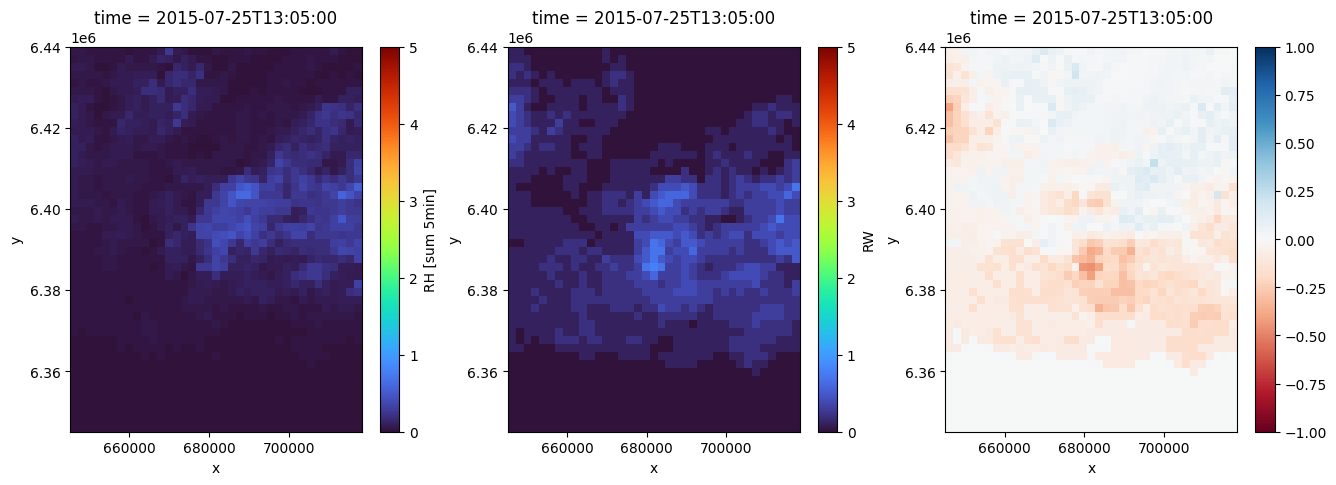

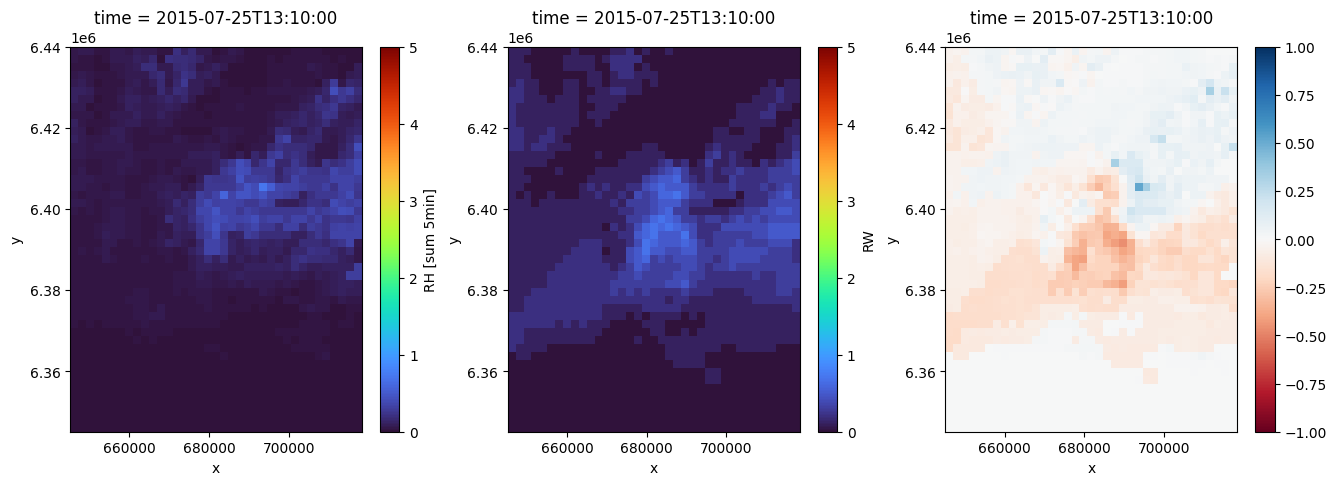

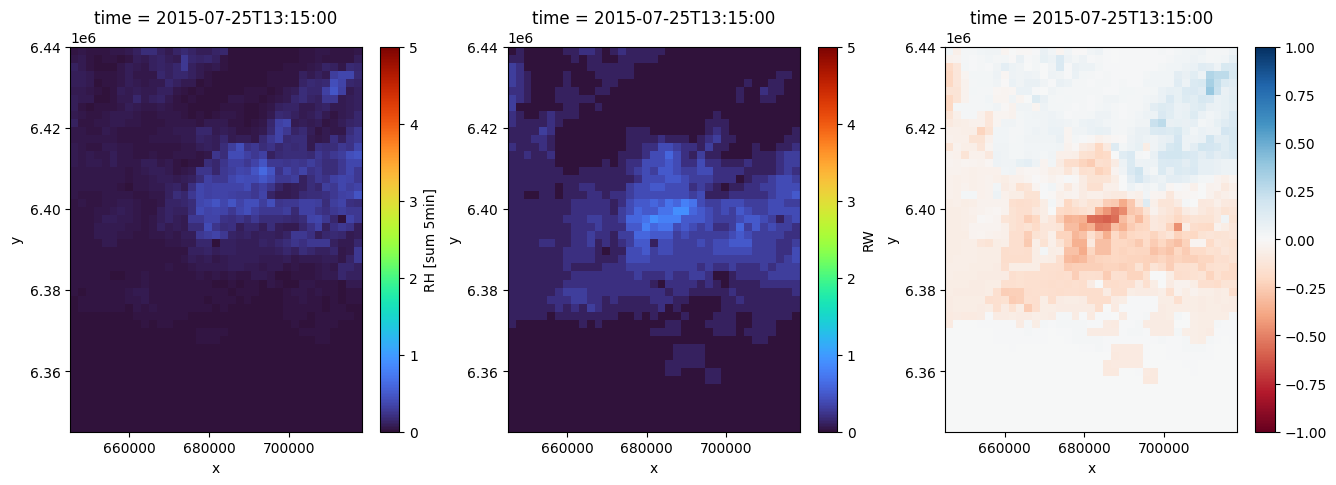

In [18]:
for t in ds_radolan.time.data[5:10]:
    vmin, vmax = 0, 5
    cmap = "turbo"
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    ds_radolan.sel(time=t).RH.plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap=cmap)
    ds_radolan.sel(time=t).RW.plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap=cmap)
    (ds_radolan.sel(time=t).RH - ds_radolan.sel(time=t).RW).plot(
        ax=axs[2],
        vmin=-1,
        vmax=1,
        cmap="RdBu",
    )

In [19]:
ds_rad.coords["lon"] = ds_rad.longitudes
ds_rad.coords["lat"] = ds_rad.latitudes

grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges.rainfall_amount,
    nnear=1,
)

In [20]:
ds_gauges.coords["id"] = ds_gauges.station_id

In [21]:
radar_at_gauges = grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges.rainfall_amount,
)

RW_at_gauges = grid_at_points(
    da_gridded_data=ds_radolan.RW_not_rounded,
    da_point_data=ds_gauges.rainfall_amount,
)

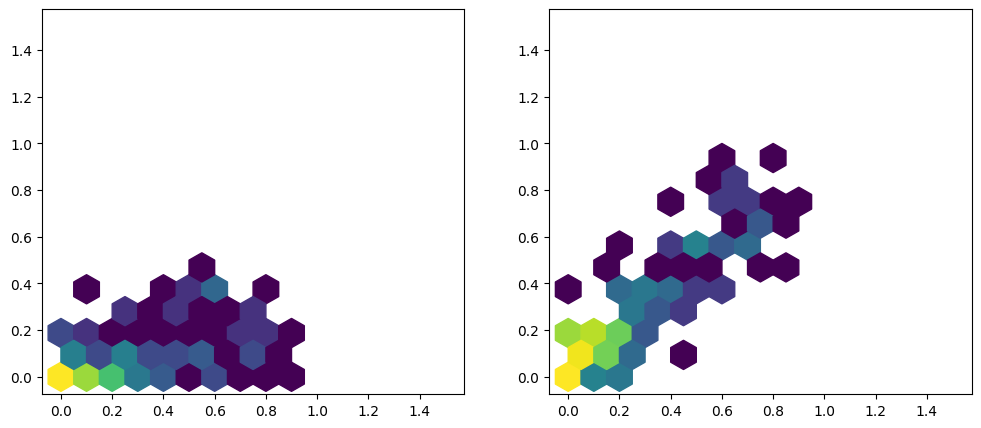

In [22]:
extent = [0, 1.5, 0, 1.5]
gridsize = 15

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hexbin(
    ds_gauges.rainfall_amount,
    radar_at_gauges,
    mincnt=1,
    extent=extent,
    gridsize=gridsize,
    bins="log",
)

axs[1].hexbin(
    ds_gauges.rainfall_amount,
    RW_at_gauges,
    mincnt=1,
    extent=extent,
    gridsize=gridsize,
    bins="log",
)

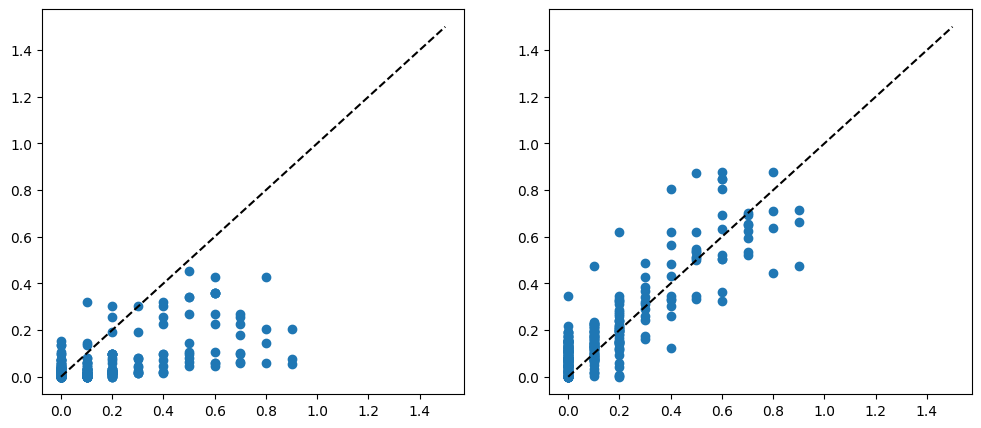

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(
    ds_gauges.rainfall_amount,
    radar_at_gauges,
)

axs[1].scatter(
    ds_gauges.rainfall_amount,
    RW_at_gauges,
)

axs[0].plot([0, 1.5], [0, 1.5], "k--")
axs[1].plot([0, 1.5], [0, 1.5], "k--")

In [24]:
np.corrcoef(ds_gauges.rainfall_amount.data.flatten(), radar_at_gauges.data.flatten())[
    0, 1
]

np.float64(0.6258268572801465)

In [25]:
np.corrcoef(ds_gauges.rainfall_amount.data.flatten(), RW_at_gauges.data.flatten())[0, 1]

np.float64(0.8664420020599064)

In [26]:
np.sqrt(
    np.mean(
        (ds_gauges.rainfall_amount.data.flatten() - RW_at_gauges.data.flatten()) ** 2
    )
)

np.float64(0.1130017913764977)